#### Importing packages 

In [1]:
import keras
import tensorflow as tf
import numpy as np
import pandas as pd
import os, shutil
from glob import glob

from sklearn.model_selection import train_test_split

Using TensorFlow backend.


#### Code to create DataFrames to map path to images with labels 

In [2]:
# creating dataframe with the path and image id 

train_origin_dir = '/home/knajf/train'
test_origin_dir = '/home/knajf/datasets/cancer/test'
df = pd.DataFrame({'path': glob(os.path.join(train_origin_dir,'*.tif'))})

# accessing the id of the image 
df['id'] = df.path.map(
    lambda x: x.split('/')[-1].split('.')[0]
)

# importing the labels and merging on 'id' column 
label_path = os.path.join('/home/knajf/datasets/cancer', 'train_labels.csv')
df_labels = pd.read_csv(filepath_or_buffer = label_path)
df = df.merge(df_labels, on = 'id')

In [3]:
df.head()

,path,id,label
0,/home/knajf/train/3297847a5ddca221a06b8562e7ca...,3297847a5ddca221a06b8562e7ca9f72f683c48d,1
1,/home/knajf/train/c7ad5078e1a5fc2f653caf53beb3...,c7ad5078e1a5fc2f653caf53beb32dbbd42cd840,1
2,/home/knajf/train/d83605d3ea636c23cb60668e6068...,d83605d3ea636c23cb60668e6068bb7a8f130492,0
3,/home/knajf/train/48aea54e6e1e1c1d99605cafe1f0...,48aea54e6e1e1c1d99605cafe1f0f4326060599a,0
4,/home/knajf/train/8a5cf51ca7c1c39f8154e644240a...,8a5cf51ca7c1c39f8154e644240a45b5795920a6,0


### Visualizing some images 

In [22]:
from skimage.io import imread
df['image'] = df['path'].map(imread)

In [26]:
df.head(50)

,path,id,label,image
0,/home/knajf/train/3297847a5ddca221a06b8562e7ca...,3297847a5ddca221a06b8562e7ca9f72f683c48d,1,"[[[183, 116, 185], [203, 130, 203], [206, 125,..."
1,/home/knajf/train/c7ad5078e1a5fc2f653caf53beb3...,c7ad5078e1a5fc2f653caf53beb32dbbd42cd840,1,"[[[92, 35, 78], [147, 91, 128], [180, 125, 154..."
2,/home/knajf/train/d83605d3ea636c23cb60668e6068...,d83605d3ea636c23cb60668e6068bb7a8f130492,0,"[[[240, 181, 201], [244, 187, 204], [222, 168,..."
3,/home/knajf/train/48aea54e6e1e1c1d99605cafe1f0...,48aea54e6e1e1c1d99605cafe1f0f4326060599a,0,"[[[203, 158, 161], [226, 180, 190], [214, 163,..."
4,/home/knajf/train/8a5cf51ca7c1c39f8154e644240a...,8a5cf51ca7c1c39f8154e644240a45b5795920a6,0,"[[[239, 234, 240], [239, 234, 240], [239, 234,..."
5,/home/knajf/train/fc361fa8f70f3b1fbc924c3d02c9...,fc361fa8f70f3b1fbc924c3d02c9175c74081dd3,0,"[[[73, 35, 74], [51, 13, 54], [123, 82, 126], ..."
6,/home/knajf/train/1521404b466eb97323632ffb3062...,1521404b466eb97323632ffb306238f5b16e810c,1,"[[[210, 191, 223], [192, 176, 203], [210, 196,..."
7,/home/knajf/train/cc4fc1af5fe54da5ac2ef59e322b...,cc4fc1af5fe54da5ac2ef59e322b34b012e8bb37,0,"[[[168, 75, 155], [206, 135, 213], [112, 68, 1..."
8,/home/knajf/train/b85270e1c3f0122d58a36a169dd6...,b85270e1c3f0122d58a36a169dd64bf83e89d9d9,1,"[[[27, 15, 89], [53, 31, 104], [66, 28, 101], ..."
9,/home/knajf/train/195472489fe194447424cf8b0555...,195472489fe194447424cf8b0555376ef9f06a4e,1,"[[[137, 77, 173], [138, 77, 170], [158, 96, 18..."


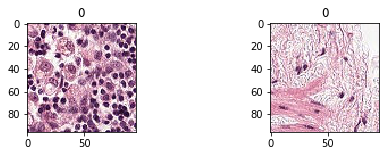

In [29]:
import matplotlib.pyplot as plt

images = [(df['image'][2], df['label'][2]), 
          (df['image'][45], df['label'][45])]

fig, m_axs = plt.subplots(1, len(images), figsize = (8, 2))
#show the images and label them
for ii, c_ax in enumerate(m_axs):
    c_ax.imshow(images[ii][0])
    c_ax.set_title(images[ii][1])
    
plt.savefig('cancer-picturesneg.png', format = 'png')

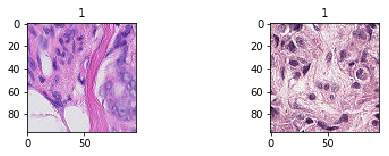

In [30]:
import matplotlib.pyplot as plt

images = [(df['image'][0], df['label'][0]),
          (df['image'][11], df['label'][11])]

fig, m_axs = plt.subplots(1, len(images), figsize = (8, 2))
#show the images and label them
for ii, c_ax in enumerate(m_axs):
    c_ax.imshow(images[ii][0])
    c_ax.set_title(images[ii][1])
    
plt.savefig('cancer-picturespos.png', format = 'png')

In [38]:
# remove image column again 
df.drop('image', inplace = True, axis = 1)
df.head()

,path,id,label
0,/home/knajf/train/3297847a5ddca221a06b8562e7ca...,3297847a5ddca221a06b8562e7ca9f72f683c48d,1
1,/home/knajf/train/c7ad5078e1a5fc2f653caf53beb3...,c7ad5078e1a5fc2f653caf53beb32dbbd42cd840,1
2,/home/knajf/train/d83605d3ea636c23cb60668e6068...,d83605d3ea636c23cb60668e6068bb7a8f130492,0
3,/home/knajf/train/48aea54e6e1e1c1d99605cafe1f0...,48aea54e6e1e1c1d99605cafe1f0f4326060599a,0
4,/home/knajf/train/8a5cf51ca7c1c39f8154e644240a...,8a5cf51ca7c1c39f8154e644240a45b5795920a6,0


#### Train-test split 

In [3]:
# train-val split 

df_train, df_val = train_test_split(df, test_size = 0.20, shuffle = True)

In [5]:
# santity check 

print(len(df_train))
print(len(df_val))

176020
44005


#### Code to run first time to create folders 

In [47]:
# creating dataset foler 

dataset_folder = os.path.join(os.getcwd(), 'datasets')
os.mkdir(dataset_folder)

FileExistsError: [Errno 17] File exists: '/home/jupyter/datasets'

In [18]:
# creating histopathologic folder 

hist_folder = os.path.join(dataset_folder, 'histopathologic')
os.mkdir(hist_folder)

In [19]:
base_dir = hist_folder

# creating training directory 
train_dir = os.path.join(base_dir, 'train')
os.mkdir(train_dir)

# creating validation directory 
validation_dir = os.path.join(base_dir, 'validation')
os.mkdir(validation_dir)

# creating test directory 
test_dir = os.path.join(base_dir, 'test')
os.mkdir(test_dir)

# creating binary class directories on training and validation paths 
train_val_paths = [train_dir, validation_dir]
for folder in train_val_paths: 
    for subfolder in ['0', '1']: 
        os.mkdir(os.path.join(folder, subfolder))

#### When data is in folders run this code to init paths 

In [8]:
# init paths
dataset_folder = os.path.join(os.getcwd(), 'datasets')
hist_folder = os.path.join(dataset_folder, 'histopathologic')
base_dir = hist_folder
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

#### Code to add data to designated folders 

In [25]:
# adding training set data to folders 

for entry in df_train['id']: 
    # get label 
    label = df_train.loc[df_train.id == entry].label.values[0]
    
    # add '.tif' to end 
    fname = entry + '.tif'
    
    # copy from source to input/train/label folder
    label_folder = os.path.join(train_dir, str(label))
    src = os.path.join(train_origin_dir, fname)
    dst = os.path.join(label_folder, fname)
    shutil.copyfile(src, dst)

In [26]:
# adding validation set data to folders

for entry in df_val['id']: 
    # get label 
    label = df_val.loc[df_val.id == entry].label.values[0]
    
    # add '.tif' to end 
    fname = entry + '.tif'
    
    # copy from source to input/train/label folder
    label_folder = os.path.join(validation_dir, str(label))
    src = os.path.join(train_origin_dir, fname)
    dst = os.path.join(label_folder, fname)
    shutil.copyfile(src, dst)

In [49]:
print('total training images labeled 0: ', len(os.listdir(os.path.join(train_dir, '0'))))
print('total training images labeled 1: ', len(os.listdir(os.path.join(train_dir, '1'))))
print('total validation images labeled 0: ', len(os.listdir(os.path.join(validation_dir, '0'))))
print('total validation images labeled 1: ', len(os.listdir(os.path.join(validation_dir, '1'))))
print('total number of images: ', len(os.listdir(os.path.join(train_dir, '0'))) + 
      len(os.listdir(os.path.join(train_dir, '1'))) + 
      len(os.listdir(os.path.join(validation_dir, '0'))) + 
      len(os.listdir(os.path.join(validation_dir, '1'))))

total training images labeled 0:  104715
total training images labeled 1:  71305
total validation images labeled 0:  26193
total validation images labeled 1:  17812
total number of images:  220025


#### Initialize ImageDataGenerator 

In [7]:
from keras.preprocessing.image import ImageDataGenerator

IMAGE_SIZE = 96 # nbr of pixels 
num_train_samples = len(df_train) # nbr of samples to train on
num_val_samples = len(df_val) # nbr of samples to perform validation on 
train_batch_size = 32 # number of samples to train on per epoch
val_batch_size = 32 # number of samples to validate on per epoch  

train_steps = np.ceil(num_train_samples / train_batch_size) # number of gradient descent steps per epoch
val_steps = np.ceil(num_val_samples / val_batch_size) 

train_datagen = ImageDataGenerator(preprocessing_function=lambda x:(x - x.mean()) / x.std() if x.std() > 0 else x,
                                  rotation_range = 90, 
                                  horizontal_flip = True,
                                  zoom_range = 0.2)
test_datagen = ImageDataGenerator(preprocessing_function=lambda x:(x - x.mean()) / x.std() if x.std() > 0 else x)

train_generator = train_datagen.flow_from_directory(
    train_dir, 
    target_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = train_batch_size, 
    class_mode = 'binary'
)

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size = (IMAGE_SIZE, IMAGE_SIZE),
        batch_size = val_batch_size,
        class_mode = 'binary'
)

Found 176020 images belonging to 2 classes.
Found 44005 images belonging to 2 classes.


In [19]:
# previously tuned model
from keras import layers 
from keras import models 

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation = 'relu', 
                        input_shape = (IMAGE_SIZE, IMAGE_SIZE, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.2))

model.add(layers.Conv2D(64, (3, 3), activation = 'relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.2))

model.add(layers.Conv2D(128, (3, 3), activation = 'relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation = 'relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.2))
model.add(layers.BatchNormalization())

model.add(layers.Flatten())
model.add(layers.Dense(512, activation = 'relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(1, activation = 'sigmoid'))

    

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 94, 94, 32)        896       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 47, 47, 32)        0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 47, 47, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 45, 45, 64)        18496     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 22, 22, 64)        0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 22, 22, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 20, 20, 128)       73856     
__________

In [20]:
from keras import optimizers

callback_list = [
    keras.callbacks.EarlyStopping(
        monitor = 'acc',
        patience = 2,
    ),
    keras.callbacks.ModelCheckpoint(
        filepath = 'my_model.h5',
        monitor = 'val_loss',
        save_best_only = True,
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor = 'val_loss',
        factor = 0.5, 
        patience = 2,
        min_lr=0.000001
    )
]
model.compile(loss = 'binary_crossentropy', 
             optimizer = optimizers.Adam(lr = 0.001),
             metrics = ['acc'])

In [21]:
history = model.fit_generator(
    train_generator, 
    steps_per_epoch = train_steps, 
    epochs = 20, 
    validation_data = validation_generator, 
    validation_steps = val_steps,
    callbacks = callback_list,
)

Epoch 1/40
5501/5501 [==============================] - 1709s 311ms/step - loss: 0.4038 - acc: 0.8208 - val_loss: 0.3772 - val_acc: 0.8378
Epoch 2/40
5501/5501 [==============================] - 1726s 314ms/step - loss: 0.3182 - acc: 0.8665 - val_loss: 0.3788 - val_acc: 0.8370
Epoch 3/40
5501/5501 [==============================] - 1735s 315ms/step - loss: 0.2838 - acc: 0.8847 - val_loss: 0.4472 - val_acc: 0.8216
Epoch 4/40
5501/5501 [==============================] - 1710s 311ms/step - loss: 0.2487 - acc: 0.9005 - val_loss: 0.4601 - val_acc: 0.8163
Epoch 5/40
5501/5501 [==============================] - 1686s 306ms/step - loss: 0.2378 - acc: 0.9058 - val_loss: 0.7050 - val_acc: 0.7800
Epoch 6/40
5501/5501 [==============================] - 1728s 314ms/step - loss: 0.2215 - acc: 0.9129 - val_loss: 0.5182 - val_acc: 0.8118
Epoch 7/40
5501/5501 [==============================] - 1708s 311ms/step - loss: 0.2131 - acc: 0.9172 - val_loss: 0.2593 - val_acc: 0.8994
Epoch 8/40
5501/5501 [=====

#### Saving the model 

In [22]:
model.save('model-40-epochs.h5')

#### Plotting training and validation accuracy and loss 

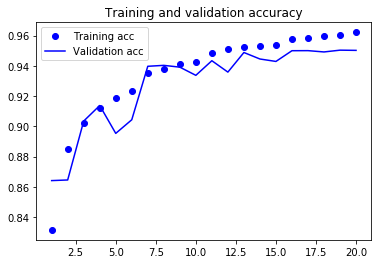

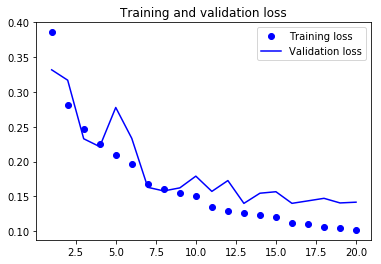

In [11]:
import matplotlib.pyplot as plt 

acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label = 'Training acc')
plt.plot(epochs, val_acc, 'b', label = 'Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'bo', label = 'Training loss')
plt.plot(epochs, val_loss, 'b', label = 'Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

#### Using a pretrained conv-net 

In [9]:
from keras.applications import VGG16

conv_base = VGG16(
    weights = 'imagenet',
    include_top = False, 
    input_shape = (96, 96, 3)
)

conv_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 96, 96, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 96, 96, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 96, 96, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 48, 48, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 48, 48, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 48, 48, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 24, 24, 128)       0         
__________

In [11]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(512, activation = 'relu'))
model.add(layers.Dense(1, activation = 'sigmoid'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 3, 3, 512)         14714688  
_________________________________________________________________
flatten_2 (Flatten)          (None, 4608)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               2359808   
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 513       
Total params: 17,075,009
Trainable params: 17,075,009
Non-trainable params: 0
_________________________________________________________________


#### Training the last layers in the pretrained network 

In [12]:
from keras.preprocessing.image import ImageDataGenerator

IMAGE_SIZE = 96 # nbr of pixels 
num_train_samples = len(df_train) # nbr of samples to train on
num_val_samples = len(df_val) # nbr of samples to perform validation on 
train_batch_size = 32 # number of samples to train on per epoch
val_batch_size = 32 # number of samples to validate on per epoch  

train_steps = np.ceil(num_train_samples / train_batch_size) # number of gradient descent steps per epoch
val_steps = np.ceil(num_val_samples / val_batch_size) 

train_datagen = ImageDataGenerator(preprocessing_function=lambda x:(x - x.mean()) / x.std() if x.std() > 0 else x)
test_datagen = ImageDataGenerator(preprocessing_function=lambda x:(x - x.mean()) / x.std() if x.std() > 0 else x)

train_generator = train_datagen.flow_from_directory(
    train_dir, 
    target_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = train_batch_size, 
    class_mode = 'binary'
)

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size = (IMAGE_SIZE, IMAGE_SIZE),
        batch_size = val_batch_size,
        class_mode = 'binary'
)

from keras import optimizers

callback_list = [
    keras.callbacks.EarlyStopping(
        monitor = 'acc',
        patience = 5,
    ),
    keras.callbacks.ModelCheckpoint(
        filepath = 'my_model.h5',
        monitor = 'val_loss',
        save_best_only = True,
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor = 'val_loss',
        factor = 0.5, 
        patience = 2,
        min_lr=0.00001
    )
]


Found 176020 images belonging to 2 classes.
Found 44005 images belonging to 2 classes.


In [16]:
conv_base.Trainable = False 

model.compile(loss = 'binary_crossentropy', 
             optimizer = optimizers.Adam(lr = 0.00001),
             metrics = ['acc'])

history = model.fit_generator(
    train_generator, 
    steps_per_epoch = train_steps, 
    epochs = 20, 
    validation_data = validation_generator, 
    validation_steps = val_steps,
    callbacks = callback_list,
)

Epoch 1/20
5501/5501 [==============================] - 6618s 1s/step - loss: 0.3385 - acc: 0.8507 - val_loss: 0.3153 - val_acc: 0.8630
Epoch 2/20
5501/5501 [==============================] - 1420s 258ms/step - loss: 0.3082 - acc: 0.8659 - val_loss: 0.3026 - val_acc: 0.8704
Epoch 3/20
5501/5501 [==============================] - 1426s 259ms/step - loss: 0.2945 - acc: 0.8734 - val_loss: 0.2932 - val_acc: 0.8744
Epoch 4/20
5501/5501 [==============================] - 1425s 259ms/step - loss: 0.2834 - acc: 0.8788 - val_loss: 0.2958 - val_acc: 0.8746
Epoch 5/20
5501/5501 [==============================] - 1409s 256ms/step - loss: 0.2754 - acc: 0.8830 - val_loss: 0.2813 - val_acc: 0.8812
Epoch 6/20
5501/5501 [==============================] - 1419s 258ms/step - loss: 0.2675 - acc: 0.8871 - val_loss: 0.2773 - val_acc: 0.8839
Epoch 7/20
5501/5501 [==============================] - 1421s 258ms/step - loss: 0.2610 - acc: 0.8901 - val_loss: 0.2731 - val_acc: 0.8857
Epoch 8/20
5501/5501 [========

In [17]:
model.save('VGG16-adam-lr-1e-4.h5')

### Trying InceptionResNetV2


In [5]:
from keras.applications.inception_resnet_v2 import InceptionResNetV2

conv_base = InceptionResNetV2(
    weights = 'imagenet',
    include_top = False, 
    input_shape = (96, 96, 3)
)

#conv_base.summary()

In [6]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(512, activation = 'relu'))
model.add(layers.Dense(1, activation = 'sigmoid'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_resnet_v2 (Model)  (None, 1, 1, 1536)        54336736  
_________________________________________________________________
flatten_1 (Flatten)          (None, 1536)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               786944    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 513       
Total params: 55,124,193
Trainable params: 55,063,649
Non-trainable params: 60,544
_________________________________________________________________


In [11]:
from keras.preprocessing.image import ImageDataGenerator

IMAGE_SIZE = 96 # nbr of pixels 
num_train_samples = len(df_train) # nbr of samples to train on
num_val_samples = len(df_val) # nbr of samples to perform validation on 
train_batch_size = 32 # number of samples to train on per epoch
val_batch_size = 32 # number of samples to validate on per epoch  

train_steps = np.ceil(num_train_samples / train_batch_size) # number of gradient descent steps per epoch
val_steps = np.ceil(num_val_samples / val_batch_size) 

train_datagen = ImageDataGenerator(preprocessing_function=lambda x:(x - x.mean()) / x.std() if x.std() > 0 else x)
test_datagen = ImageDataGenerator(preprocessing_function=lambda x:(x - x.mean()) / x.std() if x.std() > 0 else x)

train_generator = train_datagen.flow_from_directory(
    train_dir, 
    target_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = train_batch_size, 
    class_mode = 'binary'
)

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size = (IMAGE_SIZE, IMAGE_SIZE),
        batch_size = val_batch_size,
        class_mode = 'binary'
)

from keras import optimizers

callback_list = [
    keras.callbacks.EarlyStopping(
        monitor = 'acc',
        patience = 4,
    ),
    keras.callbacks.ModelCheckpoint(
        filepath = 'my_model.h5',
        monitor = 'val_loss',
        save_best_only = True,
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor = 'val_loss',
        factor = 0.5, 
        patience = 2,
        min_lr=0.000001
    )
]

Found 176020 images belonging to 2 classes.
Found 44005 images belonging to 2 classes.


In [12]:
conv_base.Trainable = False 

model.compile(loss = 'binary_crossentropy', 
             optimizer = optimizers.Adam(lr = 0.001),
             metrics = ['acc'])


history = model.fit_generator(
    train_generator, 
    steps_per_epoch = train_steps, 
    epochs = 20, 
    validation_data = validation_generator, 
    validation_steps = val_steps,
    callbacks = callback_list,
)

Epoch 1/20
5501/5501 [==============================] - 3345s 608ms/step - loss: 0.2544 - acc: 0.8975 - val_loss: 0.4098 - val_acc: 0.8167
Epoch 2/20
5501/5501 [==============================] - 3269s 594ms/step - loss: 0.3429 - acc: 0.8555 - val_loss: 0.3364 - val_acc: 0.8564
Epoch 3/20
5501/5501 [==============================] - 3266s 594ms/step - loss: 0.2578 - acc: 0.8965 - val_loss: 0.3846 - val_acc: 0.8388
Epoch 4/20
5501/5501 [==============================] - 3235s 588ms/step - loss: 0.2757 - acc: 0.8875 - val_loss: 0.4628 - val_acc: 0.8325
Epoch 5/20
5501/5501 [==============================] - 3241s 589ms/step - loss: 0.2312 - acc: 0.9084 - val_loss: 0.2096 - val_acc: 0.9213
Epoch 6/20
5501/5501 [==============================] - 3275s 595ms/step - loss: 0.1961 - acc: 0.9248 - val_loss: 0.2239 - val_acc: 0.9199
Epoch 7/20
5501/5501 [==============================] - 3297s 599ms/step - loss: 0.1958 - acc: 0.9243 - val_loss: 0.2232 - val_acc: 0.9322
Epoch 8/20
5501/5501 [=====

In [13]:
model.save('INCEPTION-adam-lr-1e-3.h5')

#### Loading model 

In [12]:
from keras.models import load_model

model = load_model('model-lr-0-001.h5')

#### Predict on validation data 

In [1]:
# predict on validation data - create new data generator that points to validation directory 

test_gen = test_datagen.flow_from_directory(
    validation_dir, 
    target_size  = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = 1,
    class_mode = 'binary',
    shuffle = False

)

predictions = model.predict_generator(test_gen, steps = len(df_val), verbose = 1)

NameError: name 'test_datagen' is not defined

#### Validation using ROC AUC and precision & recall 

1. __Precision__
_calculates the accuracy of the positive predictions of the classifier and is defined as_ 

$$\frac{TP}{TP + FP}$$

2. __Recall__
_the sensitivity (true positive rate) of the classifier and is defined as_

$$\frac{TP}{TP + FN}$$

3. The harmonic mean of precision and recall is called the F1-score and it is defined as

$$ 2* \frac{precision * recall}{precision + recall}$$

4. The ROC curve 

_Reciever operating characteristic (ROC) plots the true positive rate (recall) against false positive rate i.e. the ratio of negative instances that are incorrectly classified as positive. Equal to 1 - true negative rate which is the ratio of negative instances correctly classified as negative_

5. AUC ROC 

_The area under the ROC curve_

#### AUC ROC evaluation 

In [26]:
# get the true classes 

true_targets = test_gen.classes

In [27]:
from sklearn.metrics import roc_auc_score

roc_auc_score(true_targets, predictions)

0.9698984620108524

In [28]:
# classification report 

pred_binary = np.round(predictions)

from sklearn.metrics import classification_report

report = classification_report(true_targets, pred_binary)

print(report)

              precision    recall  f1-score   support

           0       0.92      0.94      0.93     26193
           1       0.91      0.88      0.89     17812

   micro avg       0.92      0.92      0.92     44005
   macro avg       0.91      0.91      0.91     44005
weighted avg       0.92      0.92      0.92     44005



#### Making kaggle submission 

In [14]:
# predict on test data 
test_set_dir = '/home/knajf/test/'

test_data_generator = test_datagen.flow_from_directory(
        test_set_dir,
        target_size = (IMAGE_SIZE, IMAGE_SIZE),
        batch_size = 1,
        class_mode = 'binary',
        shuffle = False 
)



Found 57458 images belonging to 1 classes.


In [16]:
# load weights from best epoch 

model.load_weights('INCEPTION-adam-lr-1e-3.h5')

In [17]:
test_predictions = model.predict_generator(test_data_generator, steps = 57458, verbose = 1)

57458/57458 [==============================] - 5476s 95ms/step


In [18]:
filenames = test_data_generator.filenames

id = [fname.split('/')[-1].split('.')[0] for fname in filenames]

submission_df = pd.DataFrame({'id':id, 
                           'label':test_predictions.reshape(-1), 
                          }).set_index('id')


In [19]:
submission_df.to_csv('histo-data-inception.csv', columns=['label']) 

In [70]:
# get current path

print(os.getcwd())

/home/jupyter
